# Chapter 6

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats
from scipy.optimize import curve_fit

warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
np.random.seed(0)

#### Code 6.1

In [3]:
np.random.seed(3)
N = 200  # num grant proposals
p = 0.1  # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw  # total score
q = np.quantile(s, 1 - p)  # top 10% threshold
selected = s >= q
cor = np.corrcoef(tw[selected], nw[selected])
cor

array([[ 1.        , -0.74495204],
       [-0.74495204,  1.        ]])

Text(0, 0.5, 'trustworthiness')

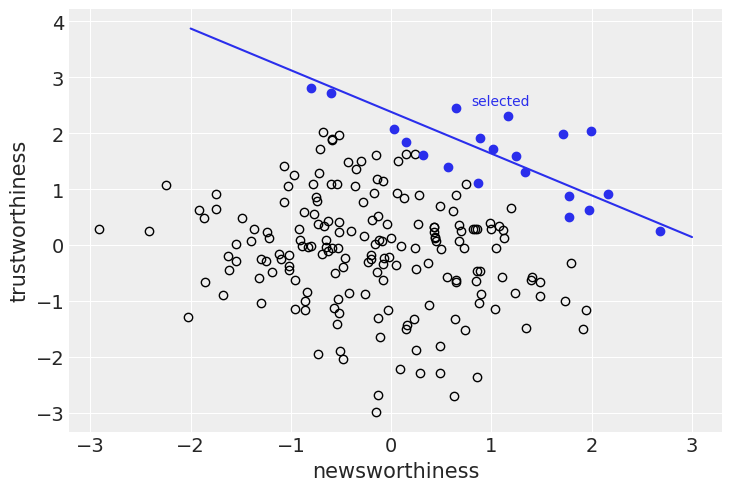

In [4]:
# Figure 6.1
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor="k", color=(0, 0, 0, 0))
plt.scatter(nw[selected], tw[selected], color="C0")
plt.text(0.8, 2.5, "selected", color="C0")

# correlation line
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()))

plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness")

#### Code 6.2

In [5]:
N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()

,height,leg_left,leg_right
0,10.178107,4.206429,4.158048
1,11.557794,4.769875,4.825845
2,12.529290,5.543952,5.529080
3,8.238977,3.853735,3.801846
4,10.472811,4.333044,4.290579


#### Code 6.3

In [6]:
with pm.Model() as m_6_1:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    br = pm.Normal("br", 2, 10)

    mu = a + bl * d["leg_left"].values + br * d["leg_right"].values
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d["height"].values)

    m_6_1_trace = pm.sample(draws=100)
    idata_6_1 = az.extract_dataset(m_6_1_trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, br, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


KeyboardInterrupt



In [7]:
az.summary(m_6_1_trace, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.96,0.35,0.35,1.44,0.02,0.02,197.84,135.28,1.02
bl,-1.57,2.20,-4.55,2.18,0.19,0.13,135.70,127.56,1.03
br,3.59,2.19,-0.07,6.65,0.19,0.13,136.46,126.32,1.03
sigma,0.65,0.05,0.58,0.72,0.00,0.00,222.94,165.44,1.01


#### Code 6.4

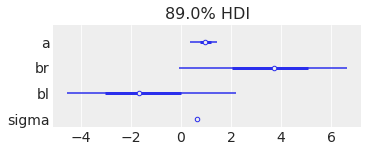

In [8]:
_ = az.plot_forest(m_6_1_trace, var_names=["a", "br", "bl", "sigma"], combined=True, figsize=[5, 2])

#### Code 6.5 & 6.6

Because we used MCMC (c.f. `quap`), the posterior samples are already in `m_6_1_trace`.

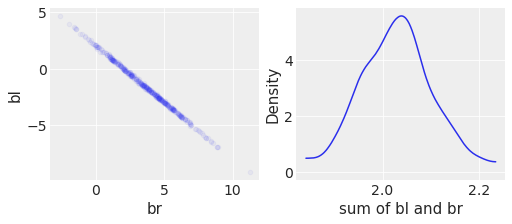

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[7, 3])

br_post = m_6_1_trace.posterior["br"].values
bl_post = m_6_1_trace.posterior["bl"].values

# code 6.5
ax1.scatter(br_post, bl_post, alpha=0.05, s=20)
ax1.set_xlabel("br")
ax1.set_ylabel("bl")

# code 6.6
az.plot_kde(br_post + bl_post, ax=ax2)
ax2.set_ylabel("Density")
ax2.set_xlabel("sum of bl and br");

#### Code 6.7

In [10]:
with pm.Model() as m_6_2:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)

    mu = a + bl * d.leg_left.values
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)

    m_6_2_trace = pm.sample()

az.summary(m_6_2_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.90,0.33,0.37,1.42,0.01,0.01,1516.91,1615.15,1.0
bl,2.04,0.07,1.93,2.16,0.00,0.00,1552.68,1741.55,1.0
sigma,0.66,0.05,0.58,0.73,0.00,0.00,1655.43,1633.22,1.0


#### Code 6.8

In [7]:
d = pd.read_csv("Data/milk.csv", sep=";")


def standardise(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


d.loc[:, "K"] = standardise(d["kcal.per.g"])
d.loc[:, "F"] = standardise(d["perc.fat"])
d.loc[:, "L"] = standardise(d["perc.lactose"])

d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


#### Code 6.9

In [8]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m_6_3:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)

    mu = a + bF * d.F.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    m_6_3_trace = pm.sample()

az.summary(m_6_3_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.14,0.12,0.0,0.0,4811.94,3104.35,1.0
bF,0.86,0.09,0.71,1.01,0.0,0.0,4592.71,2839.21,1.0
sigma,0.49,0.07,0.38,0.60,0.0,0.0,4441.97,2781.51,1.0


In [9]:
# kcal.per.g regressed on perc.lactose
with pm.Model() as m_6_4:
    a = pm.Normal("a", 0, 0.2)
    bL = pm.Normal("bF", 0, 0.5)

    mu = a + bL * d.L.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    m_6_4_trace = pm.sample()

az.summary(m_6_4_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.07,-0.11,0.11,0.0,0.0,4687.99,2971.96,1.0
bF,-0.90,0.08,-1.02,-0.78,0.0,0.0,4502.56,2852.56,1.0
sigma,0.41,0.06,0.32,0.50,0.0,0.0,3978.63,2674.02,1.0


#### Code 6.10

In [10]:
with pm.Model() as m_6_5:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    bL = pm.Normal("bL", 0, 0.5)

    mu = a + bF * d.F.values + bL * d.L.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    m_6_5_trace = pm.sample()

az.summary(m_6_5_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, bL, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.07,-0.12,0.11,0.0,0.0,2945.25,2375.18,1.0
bF,0.25,0.20,-0.05,0.57,0.0,0.0,1944.98,2037.91,1.0
bL,-0.67,0.20,-0.97,-0.35,0.0,0.0,1927.91,2110.55,1.0
sigma,0.42,0.06,0.32,0.51,0.0,0.0,1953.32,1999.73,1.0


#### Code 6.11

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


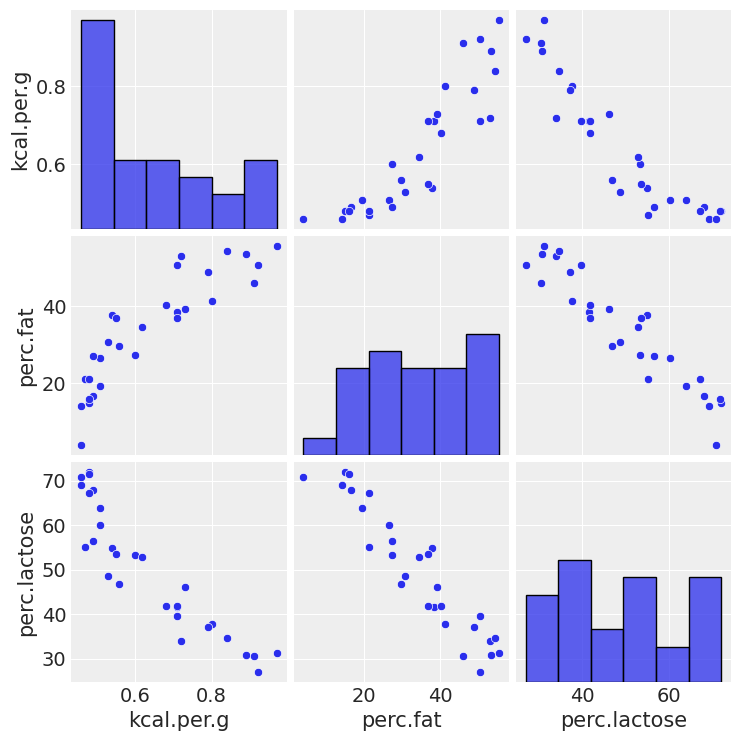

In [11]:
sns.pairplot(d.loc[:, ["kcal.per.g", "perc.fat", "perc.lactose"]]);

#### Code 6.12

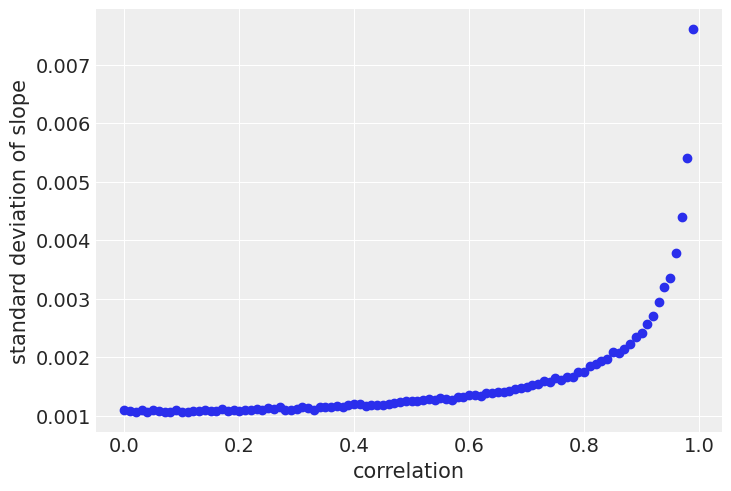

In [12]:
def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(r=0.9):
    x = np.random.normal(loc=r * d["perc.fat"], scale=np.sqrt((1 - r**2) * np.var(d["perc.fat"])))
    _, cov = curve_fit(mv, (d["perc.fat"], x), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(rep_sim_coll, r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

#### Code 6.13

In [13]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,10.19,1.95,7.15,12.93
h1,14.28,2.41,10.78,18.26
treatment,0.50,0.50,0.00,1.00
fungus,0.31,0.46,0.00,1.00


#### Code 6.14

In [14]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))

az.summary(sim_p, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
x,1.03,0.26,0.64,1.42


#### Code 6.15

In [15]:
with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_6_trace = pm.sample()

az.summary(m_6_6_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.38,0.02,1.35,1.41,0.0,0.0,4080.85,2850.10,1.0
sigma,1.95,0.14,1.73,2.17,0.0,0.0,4013.82,2478.17,1.0


#### Code 6.16

In [16]:
with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment.values + bf * d.fungus.values

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_7_trace = pm.sample()

az.summary(m_6_7_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, bf, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.45,0.02,1.42,1.50,0.0,0.0,2173.83,2462.23,1.0
bt,0.03,0.03,-0.01,0.08,0.0,0.0,2313.30,2648.32,1.0
bf,-0.28,0.03,-0.32,-0.23,0.0,0.0,2630.01,2654.20,1.0
sigma,1.30,0.09,1.16,1.45,0.0,0.0,2771.57,2201.16,1.0


#### Code 6.17

In [17]:
with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment.values

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    m_6_8_trace = pm.sample()

az.summary(m_6_8_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.30,0.03,1.26,1.34,0.0,0.0,2411.74,2819.64,1.0
bt,0.14,0.04,0.09,0.20,0.0,0.0,2279.56,2790.14,1.0
sigma,1.86,0.13,1.64,2.06,0.0,0.0,2846.05,2585.01,1.0


#### Code 6.18

Using [`causalgraphicalmodels`](https://github.com/ijmbarr/causalgraphicalmodels) for graph drawing and analysis instead of `dagitty`, following the example of [ksachdeva's Tensorflow version of Rethinking](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

C:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


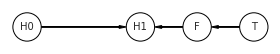

In [22]:
import daft

from causalgraphicalmodels import CausalGraphicalModel


def draw_dag(dag, coordinates):
    pgm = daft.PGM()
    for node in dag.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in dag.dag.edges:
        pgm.add_edge(*edge)
    pgm.render()
    plt.gca().invert_yaxis()


plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}

draw_dag(plant_dag, coordinates)

#### Code 6.19

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [23]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('H1', 'T', {'F'})
('T', 'H0', set())
('H0', 'F', set())


#### Code 6.20

In [18]:
N = 1000
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
M = np.random.binomial(1, 0.5, size=N)  # assumed probability 0.5 here, as not given in book
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4 + 0.4 * M, size=N)
h1 = h0 + np.random.normal(5 + 3 * M, size=N)
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,10.14,2.01,6.92,13.37
h1,16.63,2.70,11.99,20.78
treatment,0.50,0.50,0.00,1.00
fungus,0.52,0.50,0.00,1.00


Re-run m_6_6 and m_6_7 on this dataset

#### Code 6.21

Including a python implementation of the sim_happiness function

In [19]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [20]:
popn = sim_happiness(N_years=1000, seed=1977)

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(int)
# this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
age,32.00,18.77,0.0,57.00
happiness,-0.00,1.21,-2.0,1.58
married,0.28,0.45,0.0,1.00


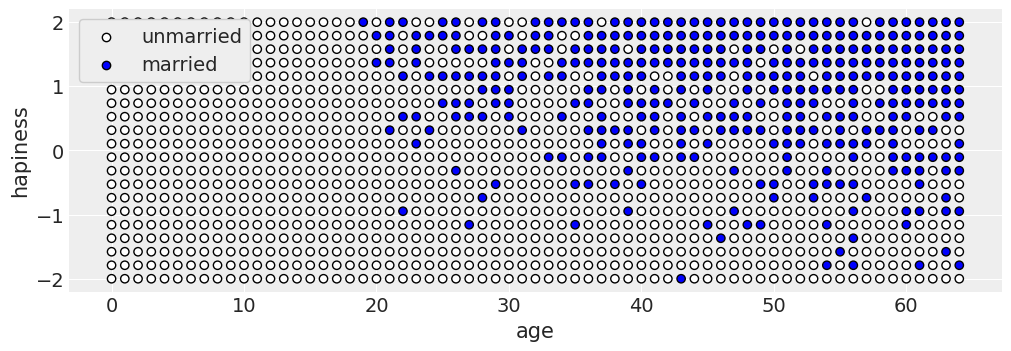

In [21]:
# Figure 6.4
fig, ax = plt.subplots(figsize=[10, 3.4])

colors = np.array(["w"] * popn.shape[0])
colors[popn.married] = "b"
ax.scatter(popn.age, popn.happiness, edgecolor="k", color=colors)

ax.scatter([], [], edgecolor="k", color="w", label="unmarried")
ax.scatter([], [], edgecolor="k", color="b", label="married")
ax.legend(loc="upper left", framealpha=1, frameon=True)

ax.set_xlabel("age")
ax.set_ylabel("hapiness");

#### Code 6.22

In [22]:
adults = popn.loc[popn.age > 17].copy()
adults.loc[:, "A"] = (adults["age"].copy() - 18) / (65 - 18)

#### Code 6.23

In [23]:
mid = adults.loc[:, "married"].astype(int).values

with pm.Model() as m_6_9:
    a = pm.Normal("a", 0, 1, shape=2)
    bA = pm.Normal("bA", 0, 2)

    mu = a[mid] + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    m_6_9_trace = pm.sample(1000)

az.summary(m_6_9_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 614 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.22,0.07,-0.32,-0.11,0.0,0.0,2114.53,2815.54,1.0
a[1],1.27,0.09,1.14,1.41,0.0,0.0,2196.74,2746.91,1.0
bA,-0.71,0.12,-0.89,-0.52,0.0,0.0,1939.83,2368.35,1.0
sigma,0.99,0.02,0.96,1.03,0.0,0.0,2858.33,2705.28,1.0


#### Code 6.24

In [24]:
with pm.Model() as m6_10:
    a = pm.Normal("a", 0, 1)
    bA = pm.Normal("bA", 0, 2)

    mu = a + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    trace_6_10 = pm.sample(1000)

az.summary(trace_6_10, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 475 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.12,0.12,0.0,0.0,1823.96,1999.47,1.0
bA,0.00,0.14,-0.22,0.22,0.0,0.0,1866.17,2022.70,1.0
sigma,1.22,0.03,1.17,1.26,0.0,0.0,2368.38,2248.45,1.0


#### Code 6.25

In [25]:
N = 200  # number of of grandparent-parent-child triads
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

#### Code 6.26

In [26]:
U = 2 * np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(size=N)
P = np.random.normal(b_GP * G + b_U * U)
C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
d = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

Text(0, 0.5, 'grandchild education (C)')

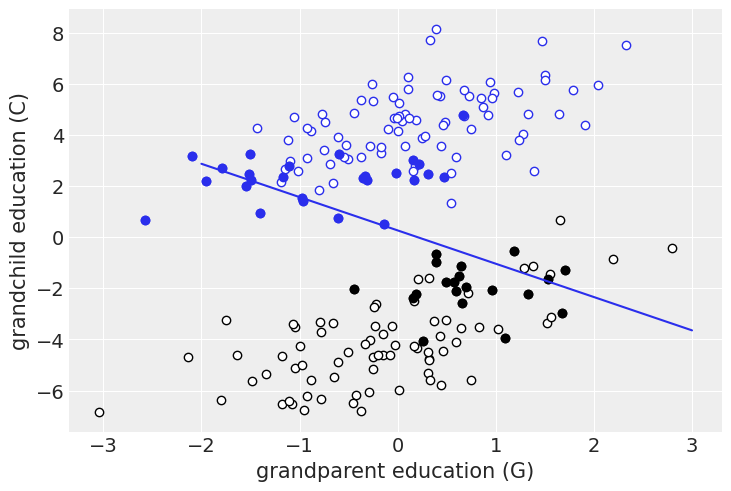

In [27]:
# Figure 6.5

# grandparent education
bad = U < 0
good = ~bad
plt.scatter(G[good], C[good], color="w", lw=1, edgecolor="C0")
plt.scatter(G[bad], C[bad], color="w", lw=1, edgecolor="k")

# parents with similar education
eP = (P > -1) & (P < 1)
plt.scatter(G[good & eP], C[good & eP], color="C0", lw=1, edgecolor="C0")
plt.scatter(G[bad & eP], C[bad & eP], color="k", lw=1, edgecolor="k")


p = np.polyfit(G[eP], C[eP], 1)
xn = np.array([-2, 3])
plt.plot(xn, np.polyval(p, xn))

plt.xlabel("grandparent education (G)")
plt.ylabel("grandchild education (C)")

#### Code 6.27

In [28]:
with pm.Model() as m_6_11:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)

    mu = a + p_PC * d.P.values + p_GC * d.G.values
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C.values)

    m_6_11_trace = pm.sample()

az.summary(m_6_11_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_PC, b_GC, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.09,-0.15,0.14,0.0,0.0,4762.93,3521.09,1.0
b_PC,1.79,0.04,1.73,1.87,0.0,0.0,3690.12,2963.64,1.0
b_GC,-0.80,0.10,-0.97,-0.64,0.0,0.0,4083.08,3163.34,1.0
sigma,1.30,0.07,1.19,1.40,0.0,0.0,4958.41,3053.76,1.0


#### Code 6.28

In [29]:
with pm.Model() as m_6_12:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)
    p_U = pm.Normal("b_U", 0, 1)

    mu = a + p_PC * d.P.values + p_GC * d.G.values + p_U * d.U.values
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C.values)

    m_6_12_trace = pm.sample()

az.summary(m_6_12_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_PC, b_GC, b_U, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 273 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.02,0.06,-0.08,0.13,0.0,0.0,3654.48,2707.61,1.0
b_PC,0.98,0.06,0.88,1.08,0.0,0.0,1586.61,2027.79,1.0
b_GC,0.05,0.09,-0.10,0.19,0.0,0.0,1859.88,2216.26,1.0
b_U,2.00,0.14,1.78,2.22,0.0,0.0,1643.00,1945.68,1.0
sigma,0.89,0.05,0.82,0.97,0.0,0.0,3675.69,2482.67,1.0


#### Code 6.29

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [ ]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
    ],
)
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

#### Code 6.30

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [ ]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[
        ("S", "A"),
        ("A", "D"),
        ("S", "M"),
        ("M", "D"),
        ("S", "W"),
        ("W", "D"),
        ("A", "M"),
    ],
)
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        print(s)

#### Code 6.31

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [ ]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

__6H1.  Use the Waffle House data, data(WaffleDivorce), to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.__

In [31]:
import os
data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")

In [32]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

In [35]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])
data["WaffleHouses_std"] = standardize(data["WaffleHouses"])

In [34]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,Divorce_std,Marriage_std,MedianAgeMarriage_std
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,1.654205,0.022644,-0.606290
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,1.544364,1.549802,-0.686699
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,0.610716,0.048974,-0.204241
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,2.093569,1.655123,-1.410387
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,-0.927058,-0.266989,0.599857


<Axes: xlabel='WaffleHouses_std', ylabel='Divorce_std'>

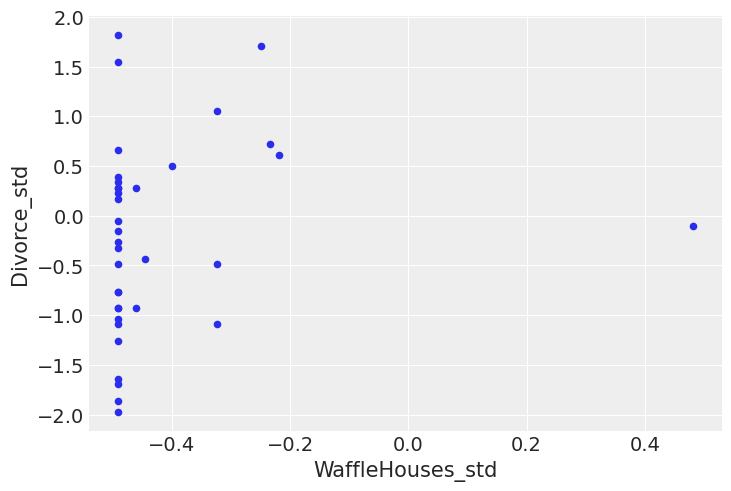

In [37]:
data[data.South==0].plot.scatter('WaffleHouses_std', 'Divorce_std')

<Axes: xlabel='WaffleHouses_std', ylabel='Divorce_std'>

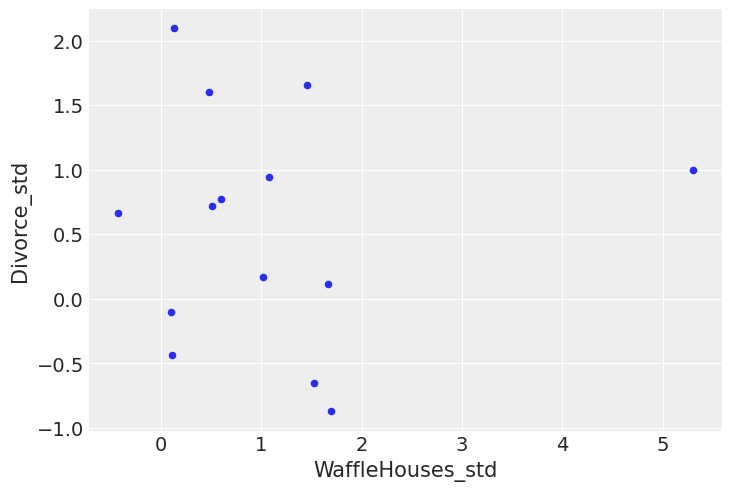

In [38]:
data[data.South==1].plot.scatter('WaffleHouses_std', 'Divorce_std')

We need to adjust for because S affects W and blocks backdoor.

In [49]:
W_shared = shared(data["WaffleHouses_std"].values)
S_shared = shared(data["South"].values)  # Should be dtype=int64

with pm.Model() as waffle_model:
    # Standardize predictors
    W = W_shared
    S = S_shared  # 0/1 indicator
    D = data["Divorce_std"]

    # Priors
    a = pm.Normal("a", 0, 0.2)
    bW = pm.Normal("bW", 0, 0.5)
    bS = pm.Normal("bS", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = a + bW * W + bS * S
    D_obs = pm.Normal("D_obs", mu, sigma, observed=D)

    # Sampling
    trace = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bW, bS, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


In [50]:
az.summary(trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.071,0.127,-0.265,0.141,0.002,0.002,2645.0,3188.0,1.0
bW,0.132,0.161,-0.118,0.394,0.003,0.002,2638.0,2733.0,1.0
bS,0.367,0.300,-0.127,0.822,0.006,0.005,2435.0,3047.0,1.0
sigma,0.977,0.103,0.817,1.142,0.002,0.002,3411.0,2903.0,1.0


In [51]:
with waffle_model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["D_obs"])

Sampling: [D_obs]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

<Axes: xlabel='D_obs'>

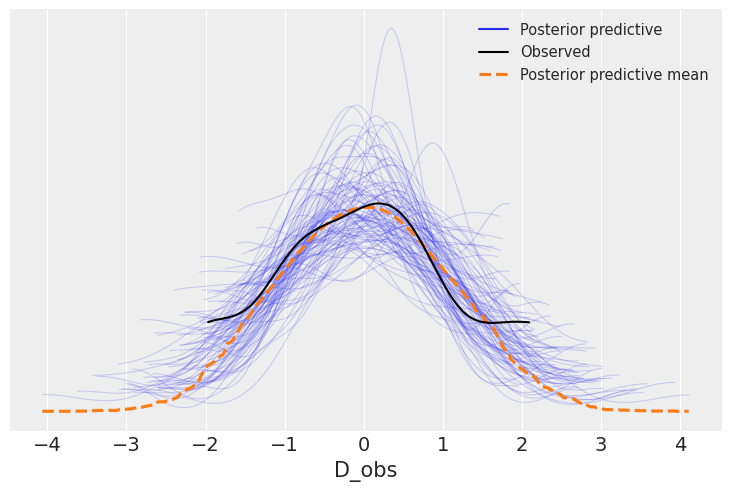

In [52]:
az.plot_ppc(posterior_predictive, num_pp_samples=100)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bW, bS, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


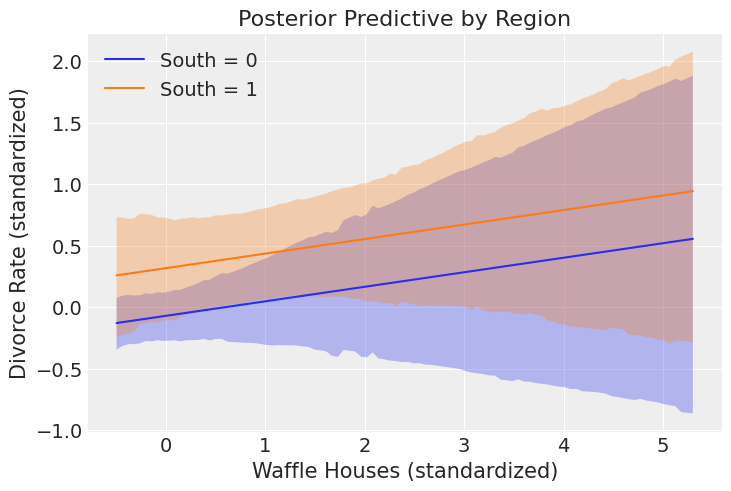

In [58]:
# --- Standardize input data ---
W_std = (data["WaffleHouses"] - data["WaffleHouses"].mean()) / data["WaffleHouses"].std()
D_std = (data["Divorce"] - data["Divorce"].mean()) / data["Divorce"].std()
S = data["South"].astype("int64")

# Shared variables for predictors
W_shared = shared(W_std.values)
S_shared = shared(S.values)

# --- TRAINING MODEL ---
with pm.Model() as model_train:
    a = pm.Normal("a", 0, 0.2)
    bW = pm.Normal("bW", 0, 0.5)
    bS = pm.Normal("bS", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = a + bW * W_shared + bS * S_shared
    D_obs = pm.Normal("D_obs", mu, sigma, observed=D_std.values)

    trace = pm.sample()

# --- PREDICTION FUNCTION ---
def predict_divorce(trace, south_value):
    # Create prediction data
    W_pred = np.linspace(W_std.min(), W_std.max(), 100)
    S_pred = np.repeat(south_value, 100)

    # Recalculate mu from trace manually
    a_samples = trace.posterior["a"].stack(draws=("chain", "draw")).values
    bW_samples = trace.posterior["bW"].stack(draws=("chain", "draw")).values
    bS_samples = trace.posterior["bS"].stack(draws=("chain", "draw")).values

    mu_pred = a_samples[:, None] + bW_samples[:, None] * W_pred + bS_samples[:, None] * S_pred

    mu_mean = mu_pred.mean(axis=0)
    hdi_mu = az.hdi(mu_pred, hdi_prob=0.89)

    return W_pred, mu_mean, hdi_mu


# --- Run predictions for both south=0 and south=1 ---
W_pred, mean0, hdi0 = predict_divorce(trace, 0)
_, mean1, hdi1 = predict_divorce(trace, 1)

# --- Plot ---
plt.plot(W_pred, mean0, label="South = 0")
plt.fill_between(W_pred, hdi0[:, 0], hdi0[:, 1], alpha=0.3)

plt.plot(W_pred, mean1, label="South = 1")
plt.fill_between(W_pred, hdi1[:, 0], hdi1[:, 1], alpha=0.3)

plt.xlabel("Waffle Houses (standardized)")
plt.ylabel("Divorce Rate (standardized)")
plt.title("Posterior Predictive by Region")
plt.legend()
plt.grid(True)
plt.show()

6H2.  Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate variables that aren’t in the data.

In [59]:
#test is wafflehouses related to south
with pm.Model() as waffle_south_model:

    # Priors
    a = pm.Normal("a", 0, 0.2)
    bS = pm.Normal("bW", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = a + bS * S
    D_obs = pm.Normal("D_obs", mu, sigma, observed=data['WaffleHouses_std'])

    # Sampling
    m_waffle_south_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bW, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [60]:
az.summary(m_waffle_south_trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.248,0.106,-0.410,-0.070,0.002,0.001,2774.0,2585.0,1.0
bW,1.145,0.218,0.823,1.513,0.004,0.003,2959.0,2656.0,1.0
sigma,0.768,0.082,0.638,0.890,0.001,0.001,3246.0,3025.0,1.0


In [61]:
#so could drop wafflehouses as this has very low effect on divorce

6H3.  Use a model to infer the total causal influence of area on weight. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range.

In [64]:
foxy = pd.read_csv("./data/foxes.csv", delimiter=",")
foxy.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [65]:
foxy.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


In [68]:
cols2std=['avgfood', 'groupsize', 'area', 'weight']
for col in cols2std:
    foxy[f'{col}_std']=standardise(foxy[col])

foxy.head()

,group,avgfood,groupsize,area,weight,avgfood_std,groupsize_std,area_std,weight_std
0,1,0.37,2,1.09,5.02,-1.924829,-1.524089,-2.239596,0.414135
1,1,0.37,2,1.09,2.84,-1.924829,-1.524089,-2.239596,-1.427046
2,2,0.53,2,2.05,5.33,-1.118035,-1.524089,-1.205508,0.675954
3,2,0.53,2,2.05,6.07,-1.118035,-1.524089,-1.205508,1.300942
4,3,0.49,2,2.12,5.85,-1.319734,-1.524089,-1.130106,1.115135


In [66]:
foxy.columns

Index(['group', 'avgfood', 'groupsize', 'area', 'weight'], dtype='object')

DAG:
area > avgfood > weight

avgfood > groupsize > weight

In [117]:
with pm.Model() as m_fox_prior:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    x = pm.Data("x", foxy['area_std'])
    mu = pm.Deterministic("mu", a + bA * x)
    weight = pm.Normal("weight", mu=mu, sigma=sigma, observed=foxy['weight_std'])
    sample = pm.sample(draws=250, chains=4, return_inferencedata=True)
    prior_preds = pm.sample_prior_predictive(samples=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 31 seconds.
Sampling: [a, bA, sigma, weight]


Text(0.5, 1.0, 'Prior Predictive Distribution of Weight')

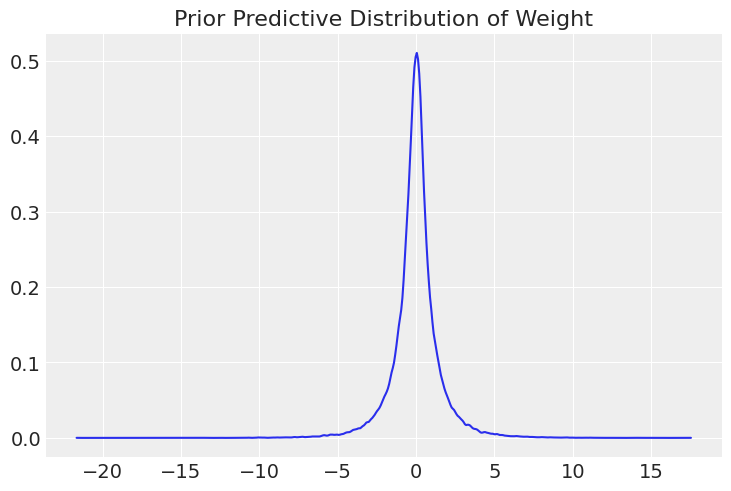

In [118]:
# Access the prior predictive samples correctly
w_sim = prior_preds.prior_predictive["weight"].values.ravel()
az.plot_dist(w_sim)
plt.title("Prior Predictive Distribution of Weight")

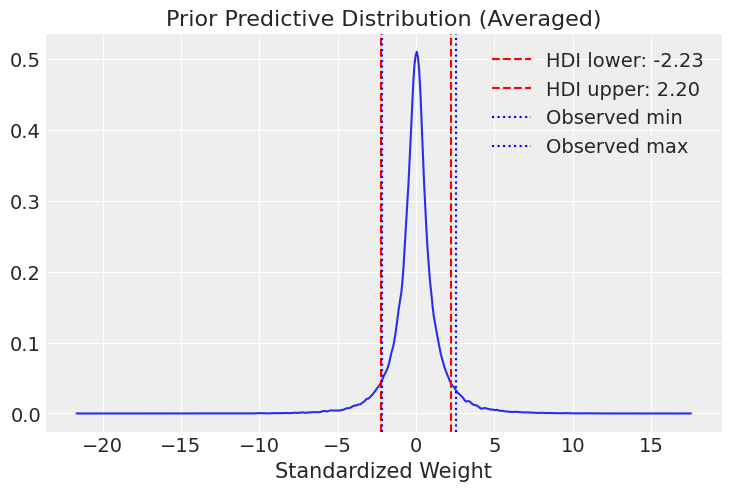

In [119]:
# Flatten to 1D: combine all prior samples across observations
w_prior = prior_preds.prior_predictive["weight"].values.ravel()

# Compute 89% HDI
hdi_bounds = az.hdi(w_prior, hdi_prob=0.89)

# Plot density with HDI
az.plot_kde(w_prior)
plt.axvline(hdi_bounds[0], color="red", linestyle="--", label=f"HDI lower: {hdi_bounds[0]:.2f}")
plt.axvline(hdi_bounds[1], color="red", linestyle="--", label=f"HDI upper: {hdi_bounds[1]:.2f}")
plt.axvline(foxy['weight_std'].min(), color="blue", linestyle=":", label="Observed min")
plt.axvline(foxy['weight_std'].max(), color="blue", linestyle=":", label="Observed max")
plt.title("Prior Predictive Distribution (Averaged)")
plt.xlabel("Standardized Weight")
plt.legend()
plt.grid(True)
plt.show()

In [120]:
az.summary(sample, var_names=["a", "bA"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.085,-0.128,0.134,0.002,0.003,1793.0,750.0,1.0
bA,0.021,0.091,-0.127,0.158,0.002,0.003,1925.0,883.0,1.0


In [150]:
with m_fox_prior:
    pm.set_data({"x": np.linspace(-3, 3, 116)})
    #ppc = pm.sample_posterior_predictive(sample, 1000, var_names=["weight", "mu"])
    ppc = pm.sample_posterior_predictive(sample, var_names=["weight", "mu"], random_seed=42)

Sampling: [weight]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

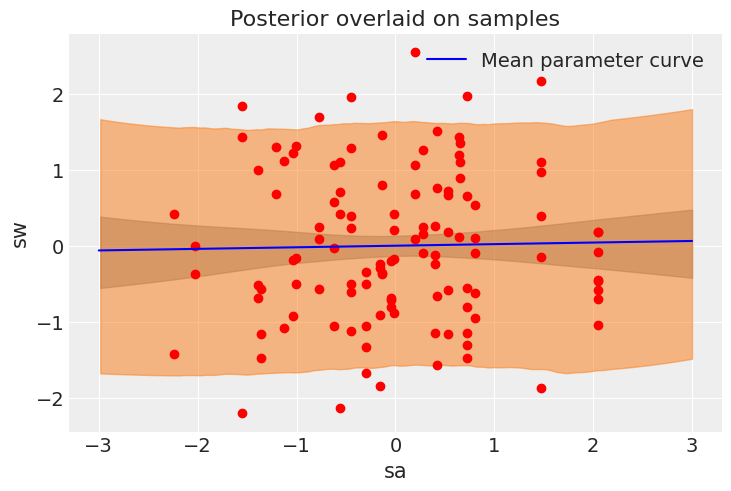

In [151]:
_, ax = plt.subplots()

x = np.linspace(-3, 3, 116)
ax.set_title("Posterior overlaid on samples")

# poster parameters
az.plot_hdi(x, ppc.posterior_predictive["mu"], ax=ax, color="grey")
ax.plot(x, ppc.posterior_predictive["mu"].mean('draw').mean('chain'), c="b", label="Mean parameter curve")

az.plot_hdi(x,
    ppc.posterior_predictive["weight"],
    ax=ax)

ax.scatter(foxy['area_std'], foxy['weight_std'], c="red")
plt.xlabel("sa")
plt.ylabel("sw")
plt.legend();

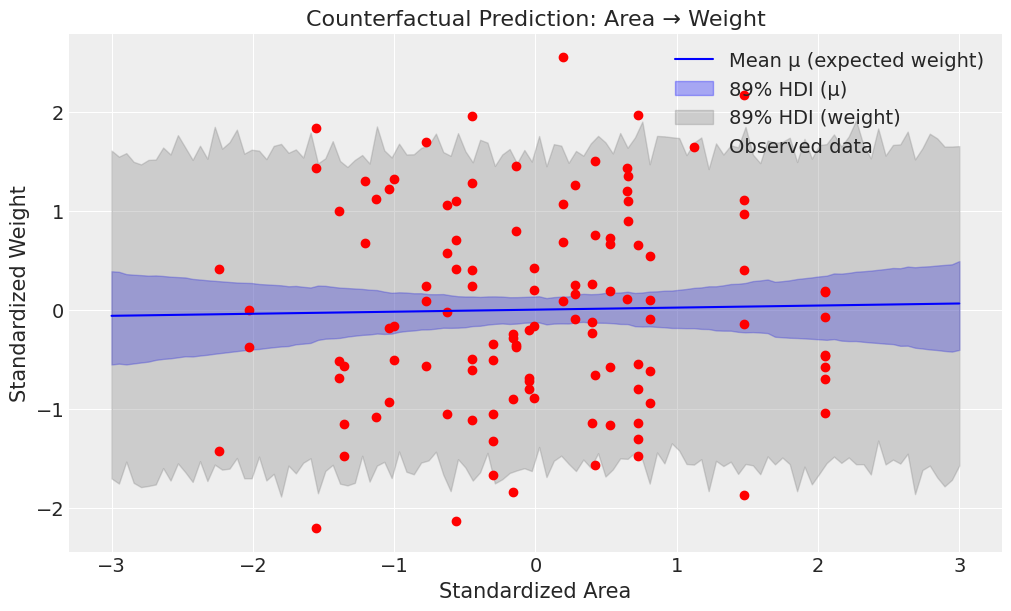

In [154]:
#do calculation manually
# Step 1: Extract posterior samples
a_samples = sample.posterior['a'].stack(draws=("chain", "draw")).values
bA_samples = sample.posterior['bA'].stack(draws=("chain", "draw")).values
sigma_samples = sample.posterior['sigma'].stack(draws=("chain", "draw")).values

# Step 2: Create counterfactual x values (standardized area)
x_vals = np.linspace(-3, 3, 116)

# Step 3: Compute predicted mu for each posterior sample and x value
mu_pred = a_samples[:, None] + bA_samples[:, None] * x_vals  # shape (n_draws, 116)

# Step 4 (optional): Draw full predictive samples
weight_pred = np.random.normal(mu_pred, sigma_samples[:, None])  # shape (n_draws, 116)

# Step 5: Compute summaries
mu_mean = mu_pred.mean(axis=0)
mu_hdi = az.hdi(mu_pred, hdi_prob=0.89)
weight_hdi = az.hdi(weight_pred, hdi_prob=0.89)

# Step 6: Plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals, mu_mean, color="blue", label="Mean μ (expected weight)")
plt.fill_between(x_vals, mu_hdi[:, 0], mu_hdi[:, 1], color="blue", alpha=0.3, label="89% HDI (μ)")

plt.fill_between(x_vals, weight_hdi[:, 0], weight_hdi[:, 1], color="gray", alpha=0.3, label="89% HDI (weight)")
plt.scatter(foxy['area_std'], foxy['weight_std'], color="red", label="Observed data")

plt.xlabel("Standardized Area")
plt.ylabel("Standardized Weight")
plt.title("Counterfactual Prediction: Area → Weight")
plt.legend()
plt.grid(True)
plt.show()

6H4.  Now infer the causal impact of adding food to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

There are no confounding backdoors between average food and weight in this model. Therefore no adjustments need to be made, and we can simply regress weight onto food without any further complications.

In [158]:
with pm.Model() as food_on_weight:
    a = pm.Normal("a", 0, 0.2)
    b = pm.Normal("b", 0, 0.5)
    x = pm.Data("x", foxy['avgfood_std'])
    mu = pm.Deterministic("mu", a + b * x)
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu=mu, sigma=sigma, observed=foxy['weight_std'])
    food_sample = pm.sample(draws=250, chains=4, return_inferencedata=True)
    food_prior_preds = pm.sample_prior_predictive(samples=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 34 seconds.
Sampling: [a, b, sigma, weight]


Text(0.5, 1.0, 'Prior Predictive Distribution of Weight (avgfood)')

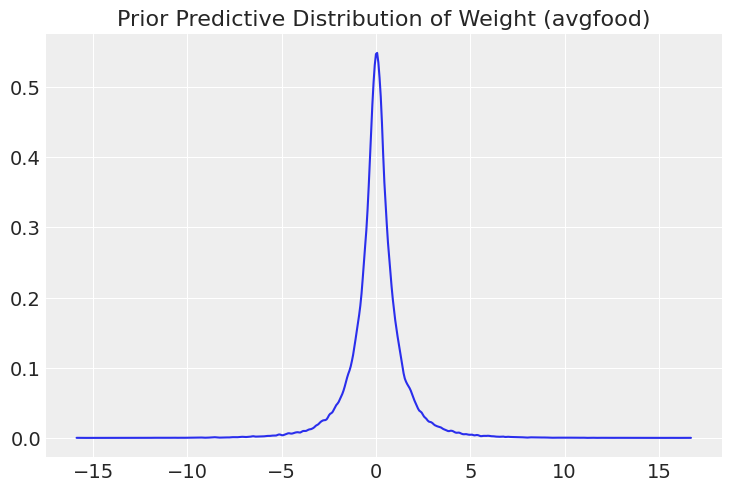

In [159]:
# Access the prior predictive samples correctly
w_sim = food_prior_preds.prior_predictive["weight"].values.ravel()
az.plot_dist(w_sim)
plt.title("Prior Predictive Distribution of Weight (avgfood)")

In [162]:
with food_on_weight:
    pm.set_data({"x": np.linspace(-3, 3, 116)})
    #ppc = pm.sample_posterior_predictive(sample, 1000, var_names=["weight", "mu"])
    ppc = pm.sample_posterior_predictive(food_sample, var_names=["weight", "mu"], random_seed=42)

Sampling: [weight]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

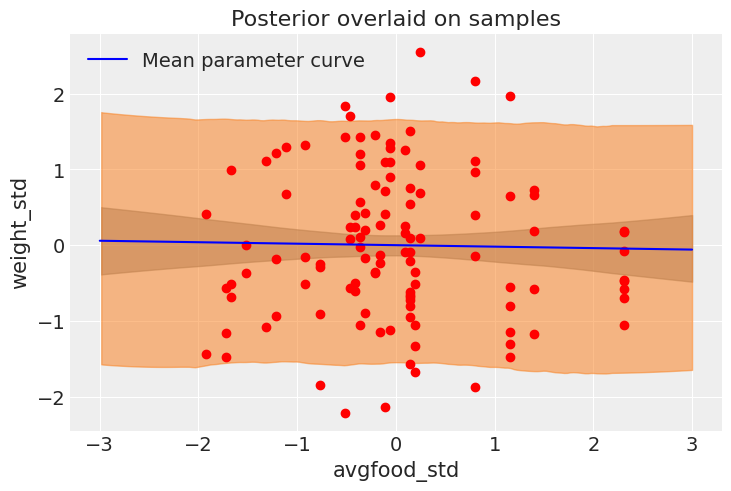

In [163]:
_, ax = plt.subplots()

x = np.linspace(-3, 3, 116)
ax.set_title("Posterior overlaid on samples")

# poster parameters
az.plot_hdi(x, ppc.posterior_predictive["mu"], ax=ax, color="grey")
ax.plot(x, ppc.posterior_predictive["mu"].mean('draw').mean('chain'), c="b", label="Mean parameter curve")

az.plot_hdi(x,
    ppc.posterior_predictive["weight"],
    ax=ax)

ax.scatter(foxy['avgfood_std'], foxy['weight_std'], c="red")
plt.xlabel("avgfood_std")
plt.ylabel("weight_std")
plt.legend();

Again, the average food appears to have no overall impact. Presumably this is due to a masking effect. This makes intuitive sense. As average food in a territory goes up, so does the group size, which simply means the larger food supply is distributed among more foxes.

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w